In [26]:
import os
import math
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2

def set_seed(s=2555304):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)

def running_in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
fileList  = [
    'X1_train.pkl','X2_train.pkl','X3_train.pkl',
    'X1_test.pkl','X2_test.pkl','X3_test.pkl',
    'y_train_.pkl','y_test_.pkl'
]
varNames = [
    'X1_train','X2_train','X3_train',
    'X1_test','X2_test','X3_test',
    'y_train_','y_test_'
]

In [28]:
if running_in_colab():
  from google.colab import drive
  drive.mount('/content/drive')
  for i, fileItem in enumerate(fileList):
    fileList[i] = "/content/drive/MyDrive/" + fileItem

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
loaded = {}
for name, fname in zip(varNames, fileList):
    with open(fname, 'rb') as f:
        loaded[name] = pickle.load(f)

globals().update(loaded)

/tmp/ipython-input-2027356381.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  loaded[name] = pickle.load(f)


In [30]:
def loader_function(X, y=None, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, normalize=True):
    """
    X: either a single np.ndarray or a list/tuple of arrays.
       Each array can be (N,H,W), (N,C,H,W) or (N,H,W,C).
       All arrays must share the same N,H,W. Channels are concatenated.
    y: optional labels (N,).
    """
    def to_nchw(a):
        a = np.asarray(a)
        assert a.ndim in (3,4), "Each X must be (N,H,W) or (N,C,H,W) or (N,H,W,C)"
        if a.ndim == 3:                 # (N,H,W) -> (N,1,H,W)
            a = a[:, None, :, :]
        elif a.ndim == 4:
            # heuristics: move channels-last to channels-first if needed
            if a.shape[1] not in (1,2,3) and a.shape[-1] in (1,2,3):
                a = np.transpose(a, (0,3,1,2))
        return a.astype(np.float32, copy=False)

    # Stack multiple inputs along channel dim
    if isinstance(X, (list, tuple)):
        xs = [to_nchw(a) for a in X]
        N, _, H, W = xs[0].shape
        for a in xs[1:]:
            assert a.shape[0]==N and a.shape[2]==H and a.shape[3]==W, "Mismatched N/H/W across inputs"
        Xn = np.ascontiguousarray(np.concatenate(xs, axis=1))   # (N, C_total, H, W)
    else:
        Xn = np.ascontiguousarray(to_nchw(X))                   # (N, C, H, W)

    class _DS(Dataset):
        def __init__(self, Xn, y, normalize):
            self.X = Xn
            self.y = None if y is None else np.asarray(y)
            self.normalize = normalize
        def __len__(self): return self.X.shape[0]
        def __getitem__(self, i):
            x = torch.from_numpy(self.X[i])  # (C,H,W), float32
            if self.normalize:
                m = x.mean(dim=(1,2), keepdim=True)
                s = x.std(dim=(1,2), keepdim=True, unbiased=False)
                x = (x - m) / (s + 1e-8)
                x = torch.nan_to_num(x)
            if self.y is None:
                return x
            yy = self.y[i]
            if not torch.is_tensor(yy):
                try: yy = torch.tensor(yy, dtype=torch.long)
                except Exception: pass
            return x, yy

    ds = _DS(Xn, y, normalize)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)

In [31]:
def train_vqvae(
    model, train_loader, val_loader, optimizer,
    device="cuda", epochs=100,
    beta_start=0.1, beta_end=None, warmup_epochs=2, ramp_epochs=20
):
    os.makedirs("output_images", exist_ok=True)
    model.to(device)

    if beta_end is None:
        beta_end = float(model.quantizer.beta)

    train_total, val_total = [], []
    train_recon, train_vq = [], []
    code_usage_hist, perplexity_hist = [], []

    K = getattr(model.quantizer, "num_embeddings", None)

    for epoch in range(1, epochs + 1):
        # ---------------- beta schedule + quantize gate ----------------
        if epoch <= warmup_epochs:
            beta_now = beta_start
            quantize_now = False
        elif epoch <= warmup_epochs + ramp_epochs:
            p = (epoch - warmup_epochs) / float(ramp_epochs)
            beta_now = beta_start + p * (beta_end - beta_start)
            quantize_now = True
        else:
            beta_now = beta_end
            quantize_now = True
        model.quantizer.beta = float(beta_now)

        # --------------------------- TRAIN ----------------------------
        model.train()
        total_loss_sum = 0.0
        recon_loss_sum = 0.0
        vq_loss_sum = 0.0
        n_train = 0

        counts_epoch = None if K is None else np.zeros(K, dtype=np.int64)

        for batch in train_loader:
            # unwrap (x, y) -> x, or list/tuple -> first element
            xb = batch[0] if isinstance(batch, (list, tuple)) else batch
            xb = xb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            out = model(xb, quantize=quantize_now)  # expects dict with total/recon/vq/indices
            loss = out["total_loss"]
            loss.backward()
            optimizer.step()

            bs = xb.size(0)
            n_train += bs
            total_loss_sum += out["total_loss"].item() * bs
            recon_loss_sum += out["recon_loss"].item() * bs
            vq_loss_sum    += out["vq_loss"].item() * bs

            # accumulate code counts (epoch-level) for usage/perplexity
            if quantize_now and (K is not None) and ("indices" in out) and (out["indices"] is not None):
                idx = out["indices"]
                if isinstance(idx, (list, tuple)):
                    idx = torch.stack(idx)
                idx = idx.view(-1).detach().to("cpu")
                c = torch.bincount(idx, minlength=K).numpy()
                counts_epoch += c

        train_total.append(total_loss_sum / n_train)
        train_recon.append(recon_loss_sum / n_train)
        train_vq.append(vq_loss_sum / n_train)

        # ---- epoch code usage & perplexity ----
        if (counts_epoch is not None) and (counts_epoch.sum() > 0):
            code_usage = int((counts_epoch > 0).sum())
            p = counts_epoch / counts_epoch.sum()
            nz = p > 0
            H = float(-(p[nz] * np.log(p[nz])).sum())
            perplexity = float(np.exp(H))
        else:
            code_usage = 0
            perplexity = float("nan")
        code_usage_hist.append(code_usage)
        perplexity_hist.append(perplexity)

        # -------------------------- VALIDATE --------------------------
        model.eval()
        val_sum = 0.0
        n_val = 0
        with torch.no_grad():
            for batch in val_loader:
                xb = batch[0] if isinstance(batch, (list, tuple)) else batch
                xb = xb.to(device, non_blocking=True)

                out = model(xb, quantize=quantize_now)
                bs = xb.size(0)
                n_val += bs
                val_sum += out["total_loss"].item() * bs

        val_total.append(val_sum / n_val)

        print(f"[Epoch {epoch:03d}] β={beta_now:.3f} "
              f"Q={'on' if quantize_now else 'off'} | "
              f"Train {train_total[-1]:.4f} | Val {val_total[-1]:.4f} | "
              f"Recon {train_recon[-1]:.4f} | VQ {train_vq[-1]:.4f} | "
              f"Codes {code_usage_hist[-1]} | Perp {perplexity_hist[-1]:.1f}")

    # ---------------------------- PLOTS ------------------------------
    ep = range(1, epochs + 1)
    plt.figure(figsize=(14, 9))
    plt.subplot(2,3,1); plt.plot(ep, train_total, label='Train'); plt.plot(ep, val_total, label='Val'); plt.title("Total Loss"); plt.legend()
    plt.subplot(2,3,2); plt.plot(ep, train_recon, label='Recon'); plt.title("Reconstruction Loss"); plt.legend()
    plt.subplot(2,3,3); plt.plot(ep, train_vq, label='VQ'); plt.title("VQ Loss"); plt.legend()
    plt.subplot(2,3,4); plt.plot(ep, code_usage_hist, label='Unique Codes'); plt.title("Code Usage"); plt.legend()
    plt.subplot(2,3,5); plt.plot(ep, perplexity_hist, label='Perplexity'); plt.title("Codebook Perplexity"); plt.legend()
    plt.tight_layout()
    plt.savefig("output_images/Training_graphs.png")
    plt.show()

    # return {
    #     "train_total": train_total,
    #     "val_total": val_total,
    #     "train_recon": train_recon,
    #     "train_vq": train_vq,
    #     "code_usage": code_usage_hist,
    #     "perplexity": perplexity_hist,
    # }


In [32]:
TrainLoad = loader_function([X1_train, X2_train, X3_train], y_train_, num_workers=0)
TestLoad  = loader_function([X1_test,  X2_test,  X3_test],  y_test_,  num_workers=0)

In [33]:
from vqmodelMulti import VQVAE_Multi

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VQVAE_Multi(in_channels=3, embedding_dim=128, num_embeddings=512, beta=0.25).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

[Epoch 001] β=0.010 Q=off | Train 0.5422 | Val 0.2263 | Recon 0.5422 | VQ 0.0000 | Codes 0 | Perp nan
[Epoch 002] β=0.010 Q=off | Train 0.1536 | Val 0.0990 | Recon 0.1536 | VQ 0.0000 | Codes 0 | Perp nan
[Epoch 003] β=0.014 Q=on | Train 7.1455 | Val 28.2175 | Recon 0.6642 | VQ 6.4814 | Codes 120 | Perp 10.0
[Epoch 004] β=0.018 Q=on | Train 189.2940 | Val 586.0314 | Recon 0.5241 | VQ 188.7699 | Codes 105 | Perp 6.9
[Epoch 005] β=0.022 Q=on | Train 1616.4937 | Val 3175.8180 | Recon 0.5207 | VQ 1615.9730 | Codes 114 | Perp 6.8
[Epoch 006] β=0.026 Q=on | Train 4132.7415 | Val 4520.1107 | Recon 0.4765 | VQ 4132.2650 | Codes 137 | Perp 4.7
[Epoch 007] β=0.030 Q=on | Train 3759.1704 | Val 3191.6235 | Recon 0.4359 | VQ 3758.7346 | Codes 145 | Perp 4.2
[Epoch 008] β=0.034 Q=on | Train 2803.1939 | Val 2399.5959 | Recon 0.4107 | VQ 2802.7832 | Codes 146 | Perp 4.0
[Epoch 009] β=0.038 Q=on | Train 2114.7676 | Val 1898.1572 | Recon 0.3913 | VQ 2114.3763 | Codes 163 | Perp 3.8
[Epoch 010] β=0.042 Q=

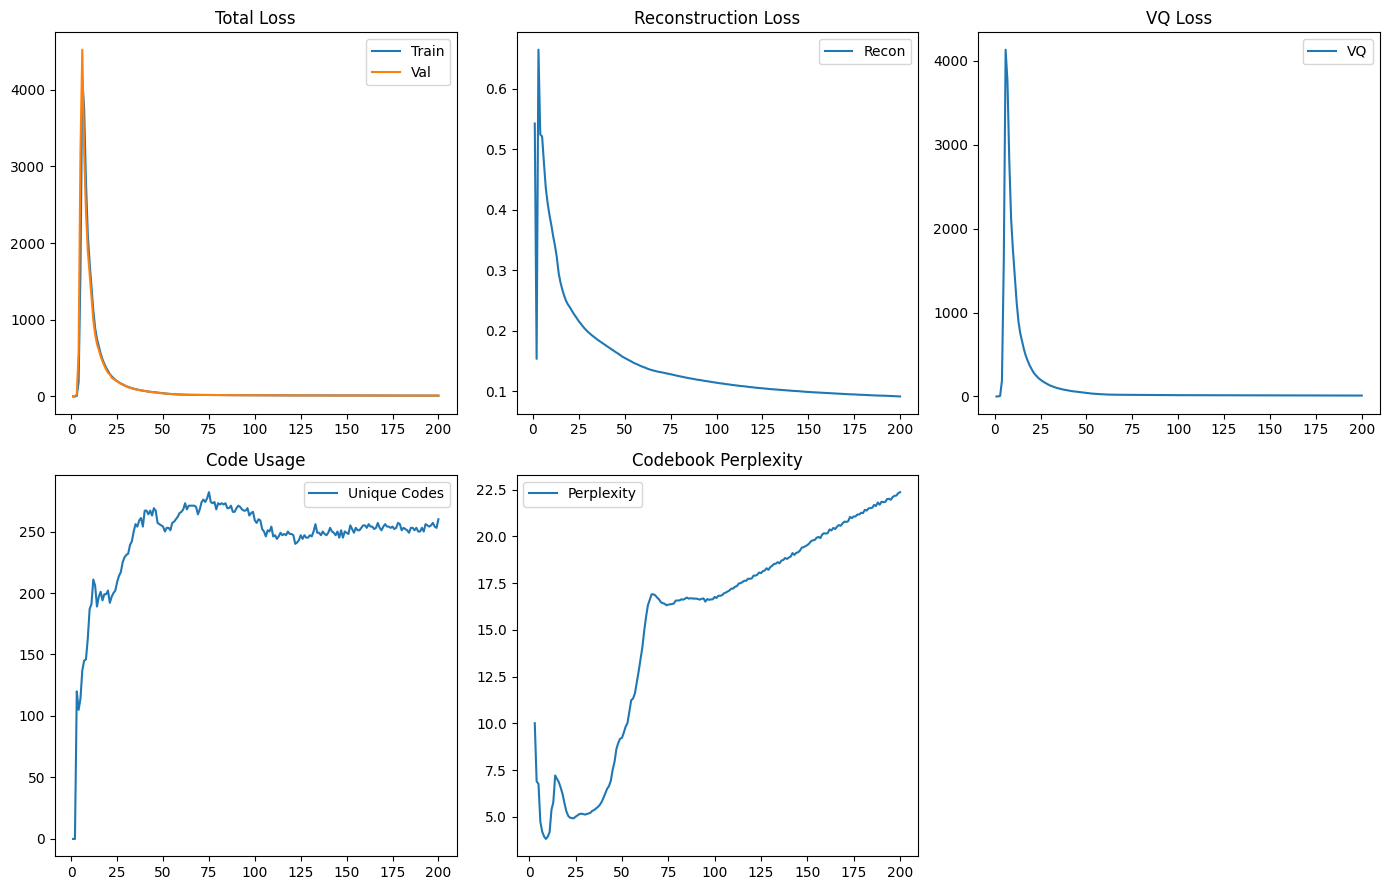

In [35]:
# train_vqvae(model, TrainLoad, TestLoad, optimizer, epochs=100)

train_vqvae(model, TrainLoad, TestLoad, optimizer,
            epochs=200, beta_start=0.01, beta_end=0.25, warmup_epochs=2, ramp_epochs=60)

In [36]:
os.makedirs("model pt files", exist_ok=True)
torch.save(model.state_dict(), "model pt files/vqvae_model.pth")
torch.save(model.state_dict(), "/content/drive/MyDrive/vqvae_model.pth")

In [37]:
import numpy as np, torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def get_latent_features(model, loader, device="cuda", source="zq", pool="meanstd", ze_merge="concat"):
    """
    source: 'zq' (quantized) or 'ze' (pre-quantization)
    pool  : 'meanstd' | 'mean' | 'flat'
    ze_merge (multi-encoder only): 'concat' (default) or 'mean' to combine branches.
    """
    model.eval()
    X, y = [], []
    with torch.no_grad():
        for batch in loader:
            xb = batch[0] if isinstance(batch, (list, tuple)) else batch
            yb = batch[1] if (isinstance(batch, (list, tuple)) and len(batch) > 1) else None
            xb = xb.to(device)

            if source == "zq":
                z = model(xb, quantize=True)["z_q"]  # shared z_q: [B,C,H,W]
                zs = [z]                             # treat like single branch
            else:
                # single-encoder vs multi-encoder
                if hasattr(model, "encoders"):       # multi-encoder model
                    xs = [xb[:, i:i+1] for i in range(xb.shape[1])]
                    zs = [enc(xi) for enc, xi in zip(model.encoders, xs)]  # list of [B,C,H,W]
                else:
                    zs = [model.encoder(xb)]

            # pool per branch
            feats = []
            for z in zs:
                if pool == "meanstd":
                    m = z.mean((2,3)); s = z.std((2,3))
                    f = torch.cat([m, s], dim=1)
                elif pool == "mean":
                    f = z.mean((2,3))
                else:  # 'flat'
                    f = z.permute(0,2,3,1).reshape(z.size(0), -1)
                feats.append(f)

            # merge branches
            if len(feats) == 1:
                feat = feats[0]
            else:
                if ze_merge == "mean":
                    feat = torch.stack(feats, dim=0).mean(dim=0)   # [B,d]
                else:
                    feat = torch.cat(feats, dim=1)                 # [B, d*branches]

            X.append(feat.cpu().numpy())
            if yb is not None:
                y.append(yb.detach().cpu().numpy() if torch.is_tensor(yb) else np.asarray(yb))

    X = np.concatenate(X, axis=0)
    y = None if not y else np.concatenate(y)
    return X, y

def plot_latent_2d(X, y=None, title="Latent space (t-SNE)"):
    Xp = PCA(n_components=min(50, X.shape[1]-1)).fit_transform(X)
    X2 = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30).fit_transform(Xp)
    plt.figure(figsize=(6,5))
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=6)
    else:
        y_arr = np.asarray(y)
        y_plot = LabelEncoder().fit_transform(y_arr.astype(str)) if y_arr.dtype.kind not in "iu" else y_arr
        plt.scatter(X2[:,0], X2[:,1], c=y_plot, s=6, cmap="tab10")
    plt.title(title); plt.tight_layout(); plt.show()
    return X2


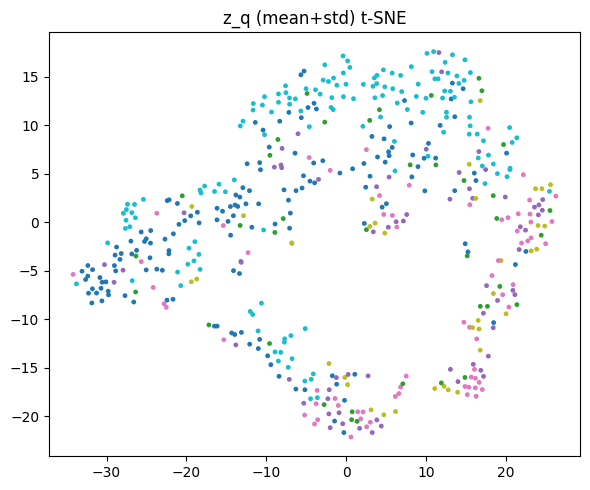

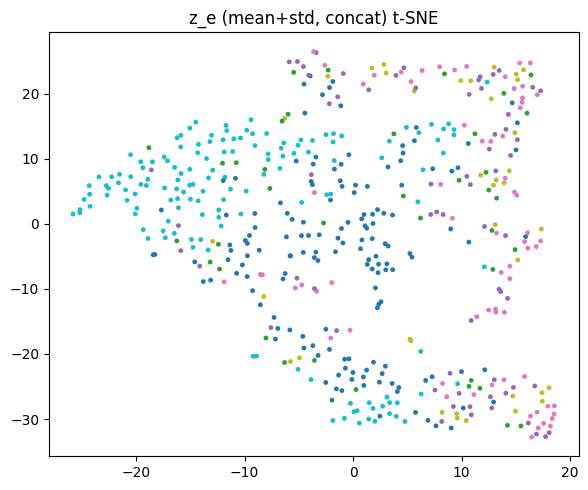

In [38]:
# Quantized latent (unchanged)
Xzq, y = get_latent_features(model, TestLoad, device=device, source="zq", pool="meanstd")
_ = plot_latent_2d(Xzq, y, "z_q (mean+std) t-SNE")

# Pre-quantization (multi-encoder aware)
Xze, y = get_latent_features(model, TestLoad, device=device, source="ze", pool="meanstd", ze_merge="concat")
_ = plot_latent_2d(Xze, y, "z_e (mean+std, concat) t-SNE")


In [39]:

import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

def code_hist_features(model, loader, device="cuda", norm="hellinger"):
    """
    Build per-sample histograms over VQ code indices.
    norm: 'none' | 'l1' | 'hellinger' (L1 -> sqrt -> L2)
    Returns: X [N,K], y (or None)
    """
    K = model.quantizer.num_embeddings
    model.eval(); X, y = [], []
    with torch.no_grad():
        for batch in loader:
            xb = batch[0] if isinstance(batch, (list, tuple)) else batch
            yb = batch[1] if (isinstance(batch, (list, tuple)) and len(batch) > 1) else None
            idx = model(xb.to(device), quantize=True)["indices"].view(xb.size(0), -1)
            for i in range(idx.size(0)):
                h = torch.bincount(idx[i], minlength=K).float()
                if norm in ("l1", "hellinger"):
                    h = h / (h.sum() + 1e-8)
                if norm == "hellinger":
                    h = torch.sqrt(h); h = h / (h.norm() + 1e-8)
                X.append(h.cpu().numpy())
            if yb is not None:
                y.append(yb.detach().cpu().numpy() if torch.is_tensor(yb) else np.asarray(yb))
    X = np.stack(X).astype(np.float32)
    y = None if not y else np.concatenate(y)
    return X, y

def plot_hist_tsne(X, y=None, title="t-SNE of code histograms"):
    Xp = PCA(n_components=min(50, X.shape[1]-1)).fit_transform(X)
    X2 = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30).fit_transform(Xp)
    plt.figure(figsize=(6,5))
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=6)
    else:
        y_arr = np.asarray(y)
        y_plot = LabelEncoder().fit_transform(y_arr.astype(str)) if y_arr.dtype.kind not in "iu" else y_arr
        plt.scatter(X2[:,0], X2[:,1], c=y_plot, s=6, cmap="tab10")
    plt.title(title); plt.tight_layout(); plt.show()
    return X2


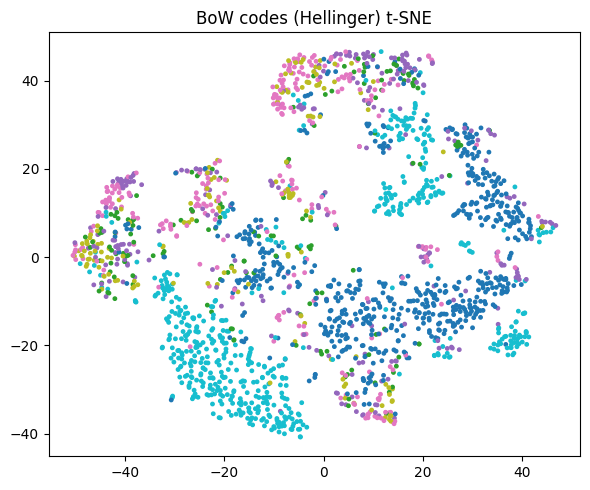

In [40]:
Xh, y = code_hist_features(model, TrainLoad, device=device, norm="hellinger")
_ = plot_hist_tsne(Xh, y, title="BoW codes (Hellinger) t-SNE")

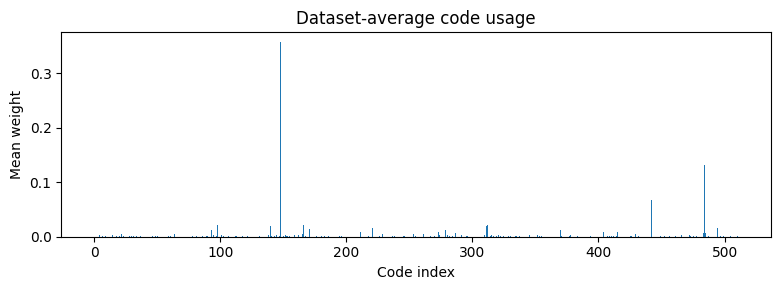

In [41]:
def plot_mean_code_usage(X_l1):
    mean_h = X_l1.mean(axis=0)
    plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(mean_h)), mean_h)
    plt.title("Dataset-average code usage"); plt.xlabel("Code index"); plt.ylabel("Mean weight")
    plt.tight_layout(); plt.show()

# call with L1 features
Xl1, _ = code_hist_features(model, TrainLoad, device=device, norm="l1")
plot_mean_code_usage(Xl1)

# KNN

Best k=31 | CV acc=0.759 (+/- 0.016) | Test acc=0.738


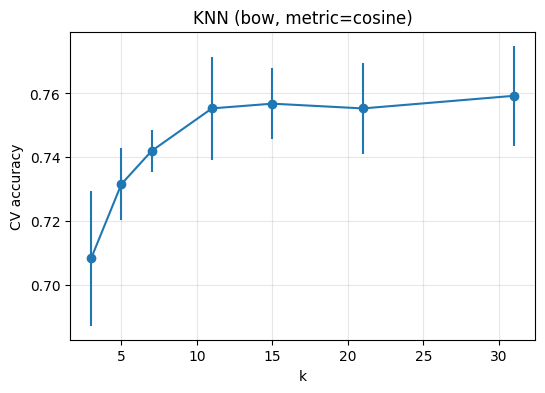

In [42]:
# model.load_state_dict(torch.load("vqvae_model.pth"))

FEAT = "bow"

if FEAT == "bow":
    Xtr, ytr = code_hist_features(model, TrainLoad, device=device, norm="hellinger")
    Xte, yte = code_hist_features(model, TestLoad,  device=device, norm="hellinger")
    metric = "cosine"     # best for histograms
    use_pca = 64          # optional small PCA
else:  # "latent"
    Xtr, ytr = get_latent_features(model, TrainLoad, device=device, source="zq", pool="meanstd")
    Xte, yte = get_latent_features(model, TestLoad,  device=device, source="zq", pool="meanstd")
    metric = "euclidean"
    use_pca = 64          # optional; set None to skip

# --- 2) tiny KNN CV + test eval ---
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

ks = [3,5,7,11,15,21,31]

def make_pipe(metric, pca_dim):
    ests = []
    ests.append(Normalizer(norm="l2") if metric == "cosine" else StandardScaler())
    if pca_dim:
        ests.append(PCA(n_components=pca_dim, whiten=True, random_state=42))
    ests.append(KNeighborsClassifier(metric=metric, weights="distance"))
    return make_pipeline(*ests)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_means, cv_stds = [], []

for k in ks:
    pipe = make_pipe(metric, use_pca)
    pipe.set_params(kneighborsclassifier__n_neighbors=k)
    scores = cross_val_score(pipe, Xtr, ytr, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_means.append(scores.mean()); cv_stds.append(scores.std())

best_k = ks[int(np.argmax(cv_means))]
best_pipe = make_pipe(metric, use_pca).set_params(kneighborsclassifier__n_neighbors=best_k)
best_pipe.fit(Xtr, ytr)
test_acc = best_pipe.score(Xte, yte)

print(f"Best k={best_k} | CV acc={max(cv_means):.3f} (+/- {cv_stds[np.argmax(cv_means)]:.3f}) "
      f"| Test acc={test_acc:.3f}")

# (optional) plot CV curve
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.errorbar(ks, cv_means, yerr=cv_stds, marker="o")
plt.xlabel("k"); plt.ylabel("CV accuracy"); plt.title(f"KNN ({FEAT}, metric={metric})")
plt.grid(True, alpha=0.3); plt.show()